In [14]:
password = "ypir iugo vmjl wxoc"
from_email = "vhp08072004@gmail.com"  # must match the email used to generate the password
to_email = "vhp08071974@gmail.com"  # receiver email

In [15]:
import smtplib

# Thông tin tài khoản gửi email
from_email = "your_email@gmail.com"
password = "your_password"
to_email = "recipient_email@example.com"
subject = "Subject of the Email"
message_body = "This is the body of the email."

# Kết nối đến máy chủ SMTP của Gmail
server = smtplib.SMTP("smtp.gmail.com", 587)
server.starttls()  # Kích hoạt chế độ bảo mật TLS

try:
    # Đăng nhập vào tài khoản Gmail
    server.login(from_email, password)
    
    # Tạo nội dung email
    message = f"Subject: {subject}\n\n{message_body}"
    
    # Gửi email
    server.sendmail(from_email, to_email, message)
    print("Email đã được gửi thành công!")
except Exception as e:
    print(f"Không thể gửi email: {e}")
finally:
    # Đóng kết nối với server
    server.quit()

Email đã được gửi thành công!


In [ ]:
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


def send_email(to_email, from_email, object_detected=1):
    """Sends an email notification indicating the number of objects detected; defaults to 1 object."""
    message = MIMEMultipart()
    message["From"] = from_email
    message["To"] = to_email
    message["Subject"] = "Security Alert"
    # Add in the message body
    message_body = f"ALERT - {object_detected} objects has been detected!!"

    message.attach(MIMEText(message_body, "plain"))
    server.sendmail(from_email, to_email, message.as_string())

In [ ]:
from time import time

import cv2
import torch

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors


class ObjectDetection:
    def __init__(self, capture_index):
        """Initializes an ObjectDetection instance with a given camera index."""
        self.capture_index = capture_index
        self.email_sent = False

        # model information
        self.model = YOLO("yolo11n.pt")

        # visual information
        self.annotator = None
        self.start_time = 0
        self.end_time = 0

        # device information
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def predict(self, im0):
        """Run prediction using a YOLO model for the input image `im0`."""
        results = self.model(im0)
        return results

    def display_fps(self, im0):
        """Displays the FPS on an image `im0` by calculating and overlaying as white text on a black rectangle."""
        self.end_time = time()
        fps = 1 / round(self.end_time - self.start_time, 2)
        text = f"FPS: {int(fps)}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)[0]
        gap = 10
        cv2.rectangle(
            im0,
            (20 - gap, 70 - text_size[1] - gap),
            (20 + text_size[0] + gap, 70 + gap),
            (255, 255, 255),
            -1,
        )
        cv2.putText(im0, text, (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)

    def plot_bboxes(self, results, im0):
        """Plots bounding boxes on an image given detection results; returns annotated image and class IDs."""
        class_ids = []
        self.annotator = Annotator(im0, 3, results[0].names)
        boxes = results[0].boxes.xyxy.cpu()
        clss = results[0].boxes.cls.cpu().tolist()
        names = results[0].names
        for box, cls in zip(boxes, clss):
            class_ids.append(cls)
            self.annotator.box_label(box, label=names[int(cls)], color=colors(int(cls), True))
        return im0, class_ids

    def __call__(self):
        """Run object detection on video frames from a camera stream, plotting and showing the results."""
        cap = cv2.VideoCapture(self.capture_index)
        assert cap.isOpened()
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        frame_count = 0
        while True:
            self.start_time = time()
            ret, im0 = cap.read()
            assert ret
            results = self.predict(im0)
            im0, class_ids = self.plot_bboxes(results, im0)

            if len(class_ids) > 0:  # Only send email If not sent before
                if not self.email_sent:
                    send_email(to_email, from_email, len(class_ids))
                    self.email_sent = True
            else:
                self.email_sent = False

            self.display_fps(im0)
            cv2.imshow("YOLO11 Detection", im0)
            frame_count += 1
            if cv2.waitKey(5) & 0xFF == 27:
                break
        cap.release()
        cv2.destroyAllWindows()
        server.quit()

In [ ]:
detector = ObjectDetection(capture_index=0)
detector()

In [2]:
import tensorflow as tf
def configure_tensorflow():
    physical_devices = tf.config.list_physical_devices()
    print("Available physical devices:")
    for device in physical_devices:
        print(device)
    
    mps_devices = tf.config.list_physical_devices('MPS')
    gpus = tf.config.list_physical_devices('GPU')
    
    if mps_devices:
        try:
            for device in mps_devices:
                tf.config.experimental.set_memory_growth(device, True)
            print(f"TensorFlow is using MPS: {[device.name for device in mps_devices]}")
            return 'MPS'
        except Exception as e:
            print(f"Error configuring TensorFlow for MPS: {e}")
    
    elif gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"TensorFlow is using GPU: {[gpu.name for gpu in gpus]}")
            return 'GPU'
        except Exception as e:
            print(f"Error configuring TensorFlow for GPU: {e}")
    
    else:
        print("TensorFlow is using CPU")
        return 'CPU'

device_tf = configure_tensorflow()

Available physical devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is using GPU: ['/physical_device:GPU:0']


In [3]:
tf.device('/MPS:0')

2024-11-05 23:54:23.163672: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-05 23:54:23.163750: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-05 23:54:23.163760: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-05 23:54:23.176072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-05 23:54:23.180916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


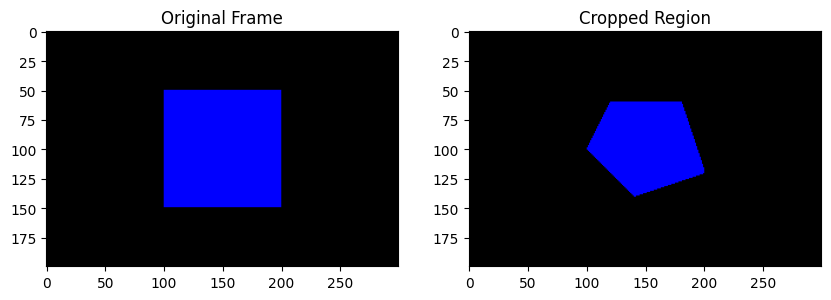

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_to_region(frame, region):
    pts = np.array(region, np.int32)
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts], 255)
    roi = cv2.bitwise_and(frame, frame, mask=mask)
    x, y, w, h = cv2.boundingRect(pts)
    roi_cropped = roi[y:y+h, x:x+w]
    return roi_cropped

# Tạo một ảnh mẫu (hoặc bạn có thể dùng một ảnh từ file)
frame = np.zeros((200, 300, 3), dtype=np.uint8)
frame[50:150, 100:200] = (255, 0, 0)  # Tạo một hình chữ nhật màu đỏ trên nền đen

# Định nghĩa vùng (đa giác) cần cắt (định dạng [x, y])
region = [(120, 60), (180, 60), (200, 120), (140, 140), (100, 100)]

# Gọi hàm crop_to_region
cropped_region = crop_to_region(frame, region)

# Hiển thị ảnh gốc và ảnh đã cắt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Frame")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Cropped Region")
plt.imshow(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))

plt.show()
